# Demonstration of the BuTools PH package

Set the precision and initialize butools (load all packages)

In [1]:
%precision %g
%run "~/github/butools/Python/BuToolsInit.py"

Butools V2.0
Packages loaded: utils, mc, moments, reptrans, trace, ph, dph, map, dmap, fitting, mam, queues
Global variables: 
butools.verbose = False , butools.checkInput = True , butools.checkPrecision = 1e-12


First the global *butools.verbose* flag is set to True to obtain more messages from the functions.

In [2]:
butools.verbose = True

## PH and ME representations

The BuTools PH package offers tools for both phase-type (PH) and matrix-exponential (ME) distributions. Some functions expect a PH representation for the input (MomentsFromPH, PdfFromPH, CdfFromPH, etc.), and some others expect an ME representation (MomentsFromME, PdfFromME, CdfFromME, etc.).

If the global flag called *butools.checkInput* is set to True, these functions enforce the proper representation of their input parameters (the corresponding tolerance is given by the global *butools.checkPrecision* variable).

The following example calls the checking functions on a distribution.

In [3]:
alpha = ml.matrix([[0.2, 0.3, 0.5]])
A = ml.matrix([[-1, 0, 0],[0, -3, 1],[0, -1, -3]])

In [4]:
CheckPHRepresentation(alpha,A)

CheckGenerator: The generator has negative off-diagonal element (precision: 1e-12)!


False

In [5]:
CheckMERepresentation(alpha,A)

True

We can conclude that $\alpha,A$ is not a PH representation, but it is a proper ME representation. (However, this does not mean that it is a valid ME distribution, the non-negativity of the density function is not checked by the CheckMERepresentation function).

Note that in the Python version of butools, the vector (like $\alpha$ above) must be given by $1\times N$ matrices.

Calling a function that needs a PH representation will fail:

In [6]:
MomentsFromPH(alpha,A)

CheckGenerator: The generator has negative off-diagonal element (precision: 1e-12)!


Exception: MomentsFromPH: Input is not a valid PH representation!

However, the ME counterpart of this function runs properly:

In [7]:
MomentsFromME(alpha,A)

[0.42, 0.504, 1.2552, 4.80768, 23.9126]

## Moment matching functions

BuTools has many functions to obtain a PH or ME distribution based on the moments. Some of them are able to return a proper result only if the input moment set falls into a given region, while some others are more flexible and have much fewer constraints.

The following function returns a PH(2) based on 3 moments. The 3 moments must fall into a given constraint, otherwise the procedure fails to return a distribution.

In [8]:
alpha, A = PH2From3Moments ([1,3,20])
print("alpha=", alpha)
print("A=", A)

alpha= [[ 0.08870534  0.91129466]]
A= [[-0.3417355   0.3417355 ]
 [ 0.         -1.35057219]]


It can be checked that the moments of the result are the same as the target moments.

In [9]:
MomentsFromPH(alpha, A)

[1, 3, 20]

The extension of the previous matching procedure: matching five moments with a PH(3) 

In [10]:
alpha, A = PH3From5Moments ([0.9,2.5,20, 500, 22000])
print("alpha=", alpha)
print("A=", A)

alpha= [[ 0.48177689  0.51619639  0.00202671]]
A= [[-4.59129254  0.          0.        ]
 [ 0.78159157 -0.78159157  0.        ]
 [ 0.          0.10577443 -0.10577443]]


In [11]:
MomentsFromPH(alpha, A)

[0.9, 2.5, 20, 500, 22000]

If the *graphviz* tool from AT&T is installed, the resulting PH distribution can be visualized by *ImageFromPH*.

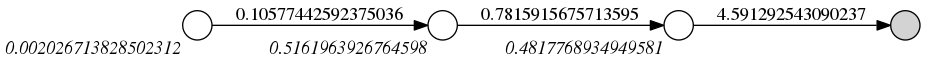

In [12]:
ImageFromPH(alpha,A)

**APHFrom3Moments** is a flexible procedure. It is able to matching *any* three moments with an appropriately large APH (acyclic PH). Let us first try to match moments [1,1.28,8] with PH2From3Moments. It fails.

In [14]:
alpha, A = PH2From3Moments ([1,1.28,8])

Exception: The given second moment is not feasible!

However, APHFrom3Moments is able to obtain a proper PH distribution, although a larger representation.

In [15]:
alpha, A = APHFrom3Moments ([1,1.28,8])
print("alpha=", alpha)
print("A=", A)

alpha= [[  3.37359608e-06   9.99996626e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00]]
A= [[-0.01496878  0.01496878  0.          0.          0.        ]
 [ 0.         -4.0009017   4.0009017   0.          0.        ]
 [ 0.          0.         -4.0009017   4.0009017   0.        ]
 [ 0.          0.          0.         -4.0009017   4.0009017 ]
 [ 0.          0.          0.          0.         -4.0009017 ]]


In [16]:
MomentsFromME(alpha, A)

[1,
 1.28,
 8,
 1640.36,
 546838,
 2.19189e+08,
 1.02501e+11,
 5.47814e+13,
 3.29374e+16]

Let us plot the feasible region of moments for APHFrom3Moments with increasing number of states. As the number of states grows, the entire region is filled.

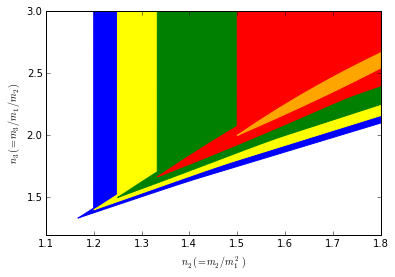

In [17]:
def feasibleBounds (n):
    ly = []
    uy = []
    x = []
    for m2 in np.linspace(APH2ndMomentLowerBound(1,n), 1.8, 500):
        # convert to normalized moments
        ml = NormMomsFromMoms ([1, m2, APH3rdMomentLowerBound(1,m2,n)])
        mu = NormMomsFromMoms ([1, m2, APH3rdMomentUpperBound(1,m2,n)])
        # record bounds
        ly.append(ml[2])
        uy.append(min(mu[2],15))
        x.append(ml[1])    
    return (x, ly, uy)

plt.ylim((1.2,3))
plt.xlim((1.1,1.8))
plt.fill_between (*feasibleBounds(6),color="blue")
plt.fill_between (*feasibleBounds(5),color="yellow")
plt.fill_between (*feasibleBounds(4),color="green")
plt.fill_between (*feasibleBounds(3),color="red")
plt.fill_between (*feasibleBounds(2),color="orange")
plt.xlabel("$n_2(=m_2/m_1^2)$")
plt.ylabel("$n_3(=m_3/m_1/m_2)$");

The next procedure, **MEFromMoments** returns a vector-matrix pair matching any number of moments. Unfortunatly, while the moments are mathcing indeed according to the moment formulas, the density function can be negative, thus *MeFromMoments* can return invalid ME distributions.

In [18]:
v, H = MEFromMoments ([0.9,2.5,20, 500, 22000])
print("v=", v)
print("H=", H)

v= [[ 0.33333333  0.33333333  0.33333333]]
H= [[ -3.49783499e+00   3.24202261e-03  -9.19120782e-01]
 [  3.26283136e+00  -8.88682123e-01   3.51400679e-01]
 [ -4.00357210e+00   1.47941382e-01  -1.09214142e+00]]


In [19]:
MomentsFromME(v, H)

[0.9, 2.5, 20, 500, 22000]

## Advanced representation transformation methods

Let us find a Markovian representation of a non-Markovian one (for instance $(v, H)$). **PHFromME** looks for a solution having the same size. Warning: it is not always possible to find a non-markovian representation of the same size. It can happen that only a larger Markovian representation exists.

In [20]:
beta, B = PHFromME (v, H)
print("beta=", beta)
print("B=", B)

beta= [[ 0.61327522  0.00135003  0.38537475]]
B= [[ -7.81879674e-01   7.20849244e-04   2.92950590e-02]
 [  5.72679365e-02  -1.05856889e-01   4.51039070e-02]
 [  4.56503384e-02   1.96793931e-03  -4.59092197e+00]]


*PHFromME* terminates successfully. To show that $(\beta,B)$ and $(v,H)$ define the same distribution, we plot it and conclude that they match.

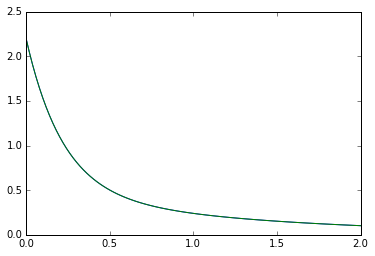

In [21]:
x = np.linspace(0, 2, 100)
y1 = PdfFromME (v, H, x)
y2 = PdfFromPH (beta, B, x)
plt.plot(x,y1,x,y2);

A more "scientific" way to prove the equivalence of the two representations is to find an appropriate similarity transformation that transforms the one to the other. The transformation matrix can be obtained by the *SimilarityMatrix* function of the *RepTrans* package.

In [22]:
T = SimilarityMatrix(B,H)
T

matrix([[  6.24967447e-02,   5.42467973e-01,   3.95035282e-01],
        [ -6.04077101e+00,   1.06478151e+00,   5.97598949e+00],
        [  7.86665051e-01,  -2.04039735e-03,   2.15375346e-01]])

Let us now check if $\beta,B$ and $v,H$ are equivalent:

In [23]:
la.norm(T.I*B*T - H)

2.30783e-14

In [24]:
la.norm(beta*T - v)

6.7987e-16

Now let us take an other example $v,H$, where no Markovian representation of the same size exists.

In [25]:
v = ml.matrix([[0.2, 0.3, 0.5]])
H = ml.matrix([[-1, 0, 0],[0, -3, 1],[0, -1, -3]])
beta, B = PHFromME (v, H)
print("beta=", beta)
print("B=", B)

beta= [[ -7.05436969e-02  -6.82275458e-05   1.07061192e+00]]
B= [[ -1.31816294e+00   1.31093892e+00   1.11093710e-03]
 [ -6.44051815e-05  -2.89744124e+00   2.88019745e+00]
 [  3.22496131e-01  -1.53830954e-01  -2.78439582e+00]]


Note that there are negative entries in $\beta$ and in the off-diagonals of $B$.
However, there is still hope to obtain a valid Markovian representation.
It has been proven that all ME distributions have a Markovian monocyclic representation.
Luckily we have a function that obtains it, called **MonocyclicPHFromME**. This function is a very strong tool. It is able to convert *any* ME distribution (ok, only those that do not touch the 0 axis apart from point 0) to a PH distribution.

In [26]:
beta, B = MonocyclicPHFromME (v, H)
print("beta=", beta)
print("B=", B)

beta= [[ 0.00550893  0.00903008  0.01693751  0.01521598  0.00535434  0.00873559
   0.05248569  0.22657249  0.66015938]]
B= [[-1.          1.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -2.42264973  2.42264973  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.         -2.42264973  2.42264973  0.          0.          0.
   0.          0.        ]
 [ 0.          0.26231725  0.         -2.42264973  2.16033248  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.         -4.24139998  4.24139998
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -4.24139998
   4.24139998  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -4.24139998  4.24139998  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
  -4.24139998  4.24139998]
 [ 0.          0.    

Altough it is larger (9 states instead of 3), but at least Markovian. 

In [27]:
CheckPHRepresentation(beta,B)

True

Let us check the cdfs now to see if they match.

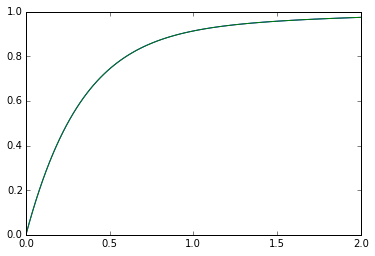

In [28]:
x = np.linspace(0, 2, 100)
y1 = CdfFromME (v, H, x)
y2 = CdfFromPH (beta, B, x)
plt.plot(x,y1,x,y2);

If the return value of *MonocyclicPHFromME* is not interesting, there is *CheckMEPositiveDensity* available to decide if the conversion to PH is possible or not, i.e. if 
the given vector-matrix pair has a non-negative density or not.

In [29]:
CheckMEPositiveDensity(v,H)

True

Let us obtain the minimal representation of this redundant representation according to controllability, observability and both respects.

In [30]:
gammac, Gc = MinimalRepFromME(beta,B,"cont")
print("controllability order = ", Gc.shape[0])
gammao, Go = MinimalRepFromME(beta,B,"obs",1e-4)
print("observability order = ", Go.shape[0])
gamma, G = MinimalRepFromME(beta,B,"obscont") # this is the default, "obscont" can be omitted
print("minimal order = ", G.shape[0])
print("Minimal representation:")
print("gamma=", gamma)
print("G=", G)

controllability order =  9
observability order =  3
minimal order =  3
Minimal representation:
gamma= [[  1.00000000e+00   6.93889390e-18   5.55111512e-17]]
G= [[ -2.83622213e+00   3.62221260e-02  -2.22044605e-16]
 [ -1.66096147e+01  -3.33690177e+00   1.60422190e+01]
 [  1.16434507e+00  -5.17235914e-02  -8.26876101e-01]]


This way we got back a $3\times 3$ representation. It is not Markovian, but it is more compact, which is beneficial in many numerical methods that use this distribution.

An other interesting tool is **MEOrderFromMoments**. Based on a set of moments it determines the minimal order of ME distribution that has those moments. For instance, it is often easy to obtain moments from several queueing models: this method can check if there is an underlying PH or ME distribution or not.

In [31]:
MEOrderFromMoments(MomentsFromPH(beta,B))

3

It managed to return the right answer. Note however, that this procedure is quite prone to numerical errors. The Mathematica implementation together with multiple (very high) precision arithmetic does not have this problem.

## Randomness

For convenience, there is a procedure to generate a random PH distribution of a given size. Further parameters are the desired order, the desired mean value, and the number of zero entries of the representation (dense random PHs are not diverse enough).

In [32]:
alpha,A = RandomPH(4, 1.2, 8)
print("alpha=",alpha)
print("A=",A)

alpha= [[ 0.35887602  0.38176327  0.25936072  0.        ]]
A= [[-11.69698763   3.5182897    4.2954947    3.88320323]
 [  0.          -6.48671354   2.39713245   3.26573336]
 [  0.           2.18860558  -2.18860558   0.        ]
 [  0.80051543   0.           0.          -2.9451668 ]]


(Zero entries can be located in the initial vector, in the generator, and in the absorbing rates as well, which is not instantly visible from the returned parameters)

The *SamplesFromPH* function returns a vector of random samples from a PH distribution. The last parameter is the number of samples requested. The samples can be used in simulations, for instance.

In [33]:
tr = SamplesFromPH(alpha,A,1000000);

In [34]:
np.mean(tr)

1.19934